In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-2bfb5098-1b7c-154c-e00e-dce2e7d965d9)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Graduation_Project/Data/CheXpert/CheXpert-v1.0-small.zip > /dev/null

In [ ]:
!pip install timm > /dev/null

In [ ]:
import cv2
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import timm

import torch 
from torch import nn
from torchsummary import summary

import torchvision.models as models
from torch.optim import Adam, lr_scheduler

from myGen import MyGen

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv('damaged_v2.csv')
data_train, data_val = train_test_split(train, test_size=0.4, random_state=42)

In [ ]:
data_train.shape, data_val.shape

((257, 2), (172, 2))

In [ ]:
data_train.reset_index(drop=True).to_csv('/content/CheXpert-v1.0-small/data_train.csv', index=False)
data_val.reset_index(drop=True).to_csv('/content/CheXpert-v1.0-small/data_val.csv', index=False)

In [ ]:
save_weights_path = '/content/drive/MyDrive/Graduation_Project/Final_Weights/damaged_data_2.pth'
load_weights_path = '/content/drive/MyDrive/Graduation_Project/Final_Weights/damaged_data_1.pth'

In [ ]:
avail_pretrained_models = timm.list_models(pretrained=True)
avail_pretrained_models

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv

In [ ]:
model = timm.create_model('efficientnet_b2', num_classes=1, pretrained=True)
model = model.cuda()

summary(model, (3, 224, 224), batch_size=32, device='cuda')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
            Conv2d-7              [32, 8, 1, 1]             264
              SiLU-8              [32, 8, 1, 1]               0
            Conv2d-9             [32, 32, 1, 1]             288
          Sigmoid-10             [32, 32, 1, 1]               0
    SqueezeExcite-11         [32, 32, 112, 112]               0
           Conv2d-12         [32, 16, 112, 112]             512
      BatchNorm2d-13         [32, 16, 112, 112]              32
         Identity-14         [32, 16, 1

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
root = '/content/'

trainGen = MyGen(image_root_path=root, 
                 csv_path='CheXpert-v1.0-small/data_train.csv', 
                 image_size=224, 
                 use_gray=False,
                 use_histoeq=False,
                 use_fourier=False,
                 use_top_bottom=False,          
                 col_to_train=['Label'])

valGen =  MyGen(image_root_path=root, 
                 csv_path='CheXpert-v1.0-small/data_val.csv', 
                 image_size=224, 
                 use_gray=False,
                 use_histoeq=False,
                 use_fourier=False,
                 use_top_bottom=False,          
                 col_to_train=['Label'])

trainloader =  torch.utils.data.DataLoader(trainGen, batch_size=32, shuffle=True)
testloader =  torch.utils.data.DataLoader(valGen, batch_size=32, shuffle=False)

# define loss & optimizer
Loss = nn.BCELoss()

optimizer = Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)  # Decay LR by a factor of 0.5 every 5 epochs

#model.load_state_dict(torch.load(load_weights_path))

# training
const_threshold = 40

val_acc_mean = 0
best_val_acc = 0
const_cnt = 0

for epoch in range(300):

    for data in trainloader:
      train_data, train_labels = data
      train_data, train_labels  = train_data.cuda(), train_labels.cuda()
      y_pred = model(train_data)
      y_pred = torch.sigmoid(y_pred)
      loss = Loss(y_pred, train_labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
    # validation  
    model.eval()
    with torch.no_grad():    
        test_pred = []
        test_true = [] 
        for data in testloader:
            test_data, test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())            
            test_true.append(test_labels.numpy())
      
        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        val_acc_mean =  accuracy_score(test_true, np.where(test_pred>0.5,1,0)) 
        model.train()

        if best_val_acc < val_acc_mean:
            const_cnt = 0
            scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
            best_val_acc = val_acc_mean
            torch.save(model.state_dict(), save_weights_path)
        else:
            const_cnt += 1
            scheduler.step()            

        if (const_cnt > const_threshold):
            const_cnt = 0 
            scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
            model.load_state_dict(torch.load(save_weights_path))
                          
        lr = get_lr(optimizer)

        print ('Epoch=%s, Val_ACC=%.4f, Best_Val_ACC=%.4f, lr=%f' %(epoch, val_acc_mean, best_val_acc, lr))

Epoch=0, Val_ACC=0.8198, Best_Val_ACC=0.8198, lr=0.001000
Epoch=1, Val_ACC=0.8779, Best_Val_ACC=0.8779, lr=0.001000
Epoch=2, Val_ACC=0.9070, Best_Val_ACC=0.9070, lr=0.001000
Epoch=3, Val_ACC=0.9477, Best_Val_ACC=0.9477, lr=0.001000
Epoch=4, Val_ACC=0.9419, Best_Val_ACC=0.9477, lr=0.001000
Epoch=5, Val_ACC=0.9419, Best_Val_ACC=0.9477, lr=0.001000
Epoch=6, Val_ACC=0.9360, Best_Val_ACC=0.9477, lr=0.001000
Epoch=7, Val_ACC=0.8953, Best_Val_ACC=0.9477, lr=0.001000
Epoch=8, Val_ACC=0.9186, Best_Val_ACC=0.9477, lr=0.001000
Epoch=9, Val_ACC=0.9360, Best_Val_ACC=0.9477, lr=0.001000
Epoch=10, Val_ACC=0.9477, Best_Val_ACC=0.9477, lr=0.001000
Epoch=11, Val_ACC=0.9302, Best_Val_ACC=0.9477, lr=0.001000
Epoch=12, Val_ACC=0.9477, Best_Val_ACC=0.9477, lr=0.001000
Epoch=13, Val_ACC=0.9593, Best_Val_ACC=0.9593, lr=0.001000
Epoch=14, Val_ACC=0.9535, Best_Val_ACC=0.9593, lr=0.001000
Epoch=15, Val_ACC=0.9651, Best_Val_ACC=0.9651, lr=0.001000
Epoch=16, Val_ACC=0.9302, Best_Val_ACC=0.9651, lr=0.001000
Epoch=1

In [ ]:
valGen =  MyGen(image_root_path='/content/', 
                 csv_path='CheXpert-v1.0-small/data_val.csv', 
                 image_size=224, 
                 use_gray=False,
                 use_histoeq=False,
                 use_fourier=False,
                 use_top_bottom=False,          
                 col_to_train=['Label'])

testloader =  torch.utils.data.DataLoader(valGen, batch_size=32, shuffle=False)

In [ ]:
model.load_state_dict(torch.load(save_weights_path))

<All keys matched successfully>

In [ ]:
# validation  
model.eval()
with torch.no_grad():    
    test_pred = []
    test_true = [] 
    for data in testloader:
        test_data, test_labels = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        test_pred.append(y_pred.cpu().detach().numpy())            
        test_true.append(test_labels.numpy())
  
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    val_acc_mean =  accuracy_score(test_true, np.where(test_pred>0.5,1,0))

In [ ]:
val_acc_mean

0.9767441860465116

In [ ]:
train = pd.read_csv('CheXpert-v1.0-small/train.csv')
train['Label'] = 0
train.to_csv('train.csv', index=False)

In [ ]:
finalGen =  MyGen(image_root_path='/content/', 
                 csv_path='train.csv', 
                 image_size=224, 
                 use_gray=False,
                 use_histoeq=False,
                 use_fourier=False,
                 use_top_bottom=False,          
                 col_to_train=['Label'])

finalloader =  torch.utils.data.DataLoader(finalGen, batch_size=32, shuffle=False)

In [ ]:
# validation  
model.eval()
with torch.no_grad():    
    test_pred = []
    for data in finalloader:
        test_data, _ = data
        test_data = test_data.cuda()
        y_pred = model(test_data)
        test_pred.append(y_pred.cpu().detach().numpy())            
  
    test_pred = np.concatenate(test_pred)

In [ ]:
len(test_pred)

223414

In [ ]:
train['Label'] = np.where(test_pred>0.5, 1, 0)
train['Label'].value_counts()

0    209621
1     13793
Name: Label, dtype: int64

In [ ]:
train[(train['Label']==1)&(train['Frontal/Lateral']=='Frontal')].shape

(4171, 20)

In [ ]:
train.to_csv('clean_data.csv', index=False)

In [ ]:
!mv /content/clean_data.csv /content/drive/MyDrive/Graduation_Project/Data/

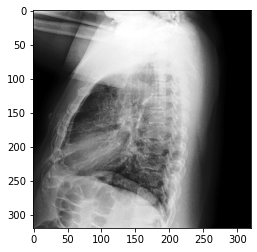

In [ ]:
plt.imshow(plt.imread(train[train['Label']==1].iloc[1532, 0]), cmap='gray')

In [ ]:
train[(train['Label']==1)&(train['Frontal/Lateral']=='Frontal')].shape

(4171, 20)

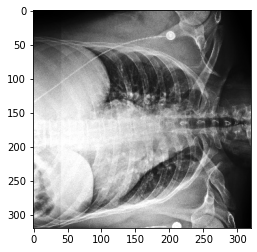

In [ ]:
img = train[(train['Label']==1)&(train['Frontal/Lateral']=='Frontal')].iloc[1500, 0]
plt.imshow(plt.imread(img), cmap='gray')